In [165]:
import pandas as pd

with open("/Users/sakshmenon/Desktop/PLM/Data Visualizing/5 Way Venn Plots/baker2fission.e1.txt") as fileobj:
    content = fileobj.read()
    lines = content.split('\n')

linewise = []
queries = []
for line in lines[:-1]:
    ph = line.split('\t')
    queries.append(ph[0])
    linewise.append({'Query' : ph[0], 'Ref' : ph[1], 'Score' : eval(ph[-2])})

df = pd.DataFrame(linewise)
top_match_list = []
for query in set(queries):
    temp = df[df['Query'] == query].sort_values('Score')
    temp = temp.iloc[0][['Query', 'Ref']].to_dict()
    temp = str(temp['Query'] + " " + str(temp['Ref']))
    top_match_list.append(temp)

top_match_list = set(top_match_list)

In [83]:
def file_ext(file, queries):
    file_list = []
    with open(file) as fileobj:
        content = fileobj.read()
        lines = content.split('\n\n')[1:-1]

    for line in lines:
        sub = line.split('\n')[:2]
        query = sub[0].split('\t')[1].split(' ')[0][1:]
        if query in set(queries):
            match = sub[1].split('\t')[2].split(' ')[0][1:]
            file_list.append(str(query) + ' ' + str(match))
    
    return set(file_list)

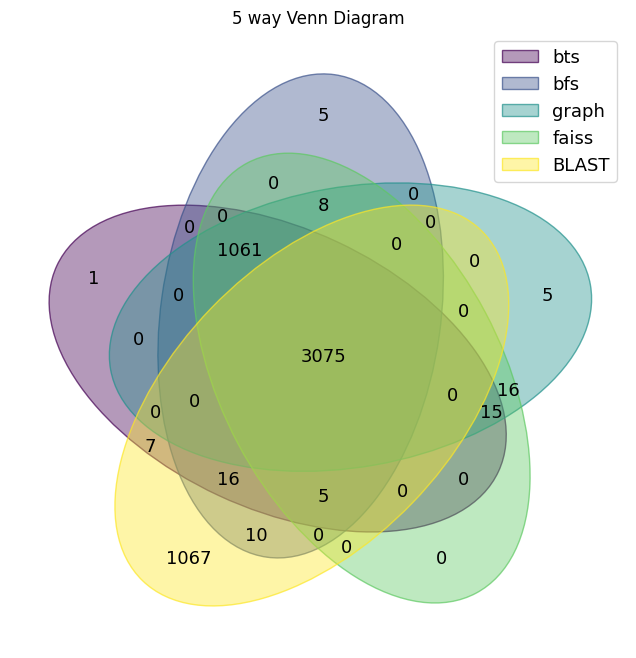

In [86]:
import os
import matplotlib.pyplot as plt
from venn import venn

def plot_venn_5_sets(sets_dict):
    venn(sets_dict)
    plt.title("5 way Venn Diagram")
    plt.show()

bts_pth = "/Users/sakshmenon/Desktop/PLM/Data Visualizing/5 Way Venn Plots/s_cerevisiae2s_pombe.bts.k30.txt"
bfs_pth = "/Users/sakshmenon/Desktop/PLM/Data Visualizing/5 Way Venn Plots/s_cerevisiae2s_pombe.bfs.k30.txt"
graph_pth = "/Users/sakshmenon/Desktop/PLM/Data Visualizing/5 Way Venn Plots/s_cerevisiae2s_pombe.graph.k30.txt"
faiss_pth = "/Users/sakshmenon/Desktop/PLM/Data Visualizing/5 Way Venn Plots/s_cerevisiae2s_pombe.faiss.k30.txt"

bts_dict = file_ext(bts_pth, queries)
bfs_dict = file_ext(bfs_pth, queries)
graph_dict = file_ext(graph_pth, queries)
faiss_dict = file_ext(faiss_pth, queries)

plot_set = {
'bts': bts_dict,
'bfs': bfs_dict,
'graph': graph_dict,
'faiss': faiss_dict,
'BLAST' : top_match_list
}

plot_venn_5_sets(plot_set)


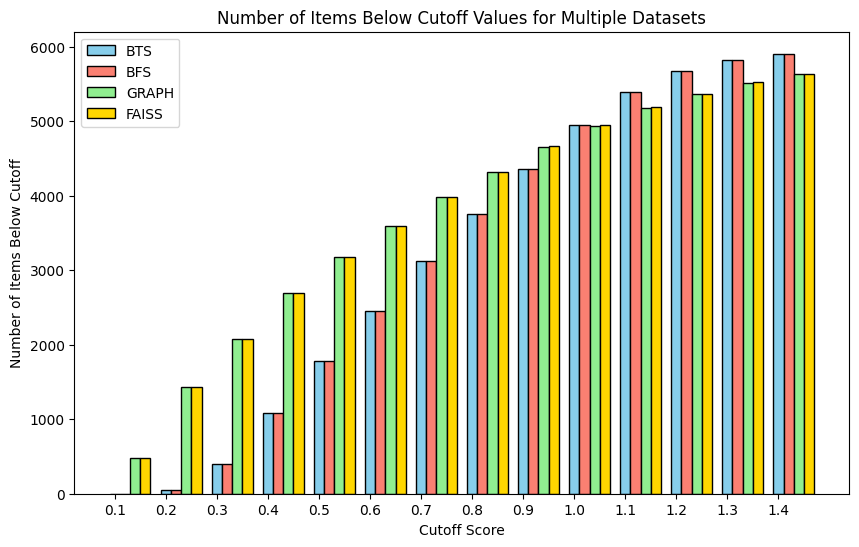

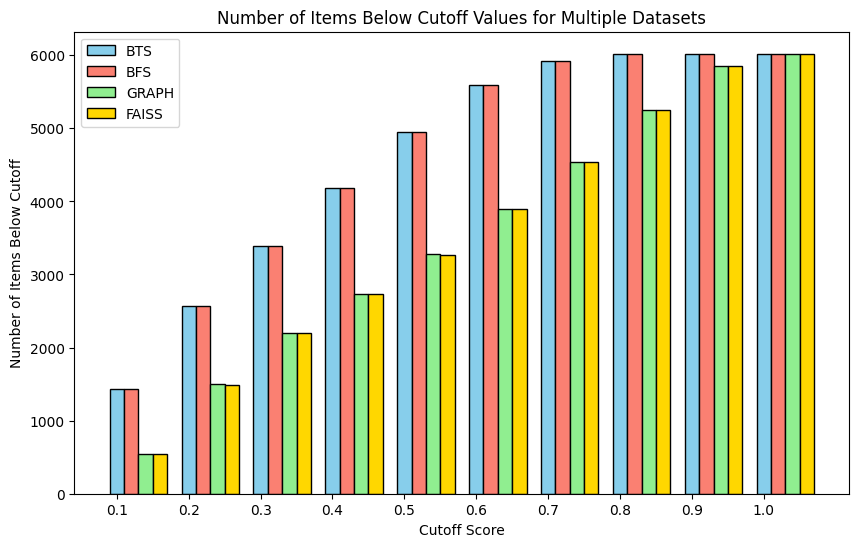

In [222]:
faiss_json = "/Users/sakshmenon/Desktop/PLM/Data Visualizing/5 Way Venn Plots/faiss_top10.json"
graph_json = "/Users/sakshmenon/Desktop/PLM/Data Visualizing/5 Way Venn Plots/graph_top10.json"
bts_json = "/Users/sakshmenon/Desktop/PLM/Data Visualizing/5 Way Venn Plots/bts_top10.json"
bfs_json = "/Users/sakshmenon/Desktop/PLM/Data Visualizing/5 Way Venn Plots/bfs_top10.json"

faiss_df = f_ext(faiss_json)
graph_df = f_ext(graph_json)
bts_df = f_ext(bts_json)
bfs_df = f_ext(bfs_json)

plot_multiple_score_distributions(1.5, bts_df['Score'], bfs_df['Score'], graph_df['Score'], faiss_df['Score'])
plot_multiple_score_distributions(1.1, bts_df['Conf'], bfs_df['Conf'], graph_df['Conf'], faiss_df['Conf'])

In [217]:
table1 = []
for i in np.arange(0.1, 1.1, 0.1):
    table1.append({'Cutoff': i, 'BTS' : len(bts_df[bts_df['Conf'] < i]), 'BFS' : len(bfs_df[bfs_df['Conf'] < i]), 
     'GRAPH' : len(graph_df[graph_df['Conf'] < i]), 'FAISS' : len(faiss_df[faiss_df['Conf'] < i])})
pd.DataFrame(table1)

,Cutoff,BTS,BFS,GRAPH,FAISS
0,0.1,1428,1428,549,538
1,0.2,2565,2565,1502,1493
2,0.3,3395,3395,2202,2193
3,0.4,4179,4179,2736,2727
4,0.5,4948,4948,3275,3268
5,0.6,5593,5593,3899,3895
6,0.7,5921,5921,4535,4533
7,0.8,6014,6014,5248,5247
8,0.9,6020,6020,5853,5853
9,1.0,6021,6021,6021,6021


In [216]:
table1 = []
for i in np.arange(0.1, 1.6, 0.1):
    table1.append({'Cutoff': i, 'BTS' : len(bts_df[bts_df['Score'] < i]), 'BFS' : len(bfs_df[bfs_df['Score'] < i]), 
     'GRAPH' : len(graph_df[graph_df['Score'] < i]), 'FAISS' : len(faiss_df[faiss_df['Score'] < i])})
pd.DataFrame(table1)

,Cutoff,BTS,BFS,GRAPH,FAISS
0,0.1,0,0,475,475
1,0.2,54,54,1432,1432
2,0.3,397,397,2083,2084
3,0.4,1078,1078,2691,2694
4,0.5,1784,1784,3178,3181
5,0.6,2453,2453,3593,3596
6,0.7,3129,3129,3984,3989
7,0.8,3760,3760,4321,4326
8,0.9,4361,4361,4660,4665
9,1.0,4945,4945,4938,4945


In [1]:
def f_ext(file):
    with open(file, 'r') as f:
        obj = json.load(f)
    main_l = []
    for q in obj:
        que = q['Query']['ID'].split(' ')[0][1:]
        t1 = q['Query']['Matches'][0]['ID'].split(' ')[0][1:]
        conf = q['Query']['Confidence']
        score = q['Query']['Matches'][0]['Score']
        main_l.append({'Query' : que, 'T1' : t1, 'Score' : score,'Conf' : conf})
    return pd.DataFrame(main_l)


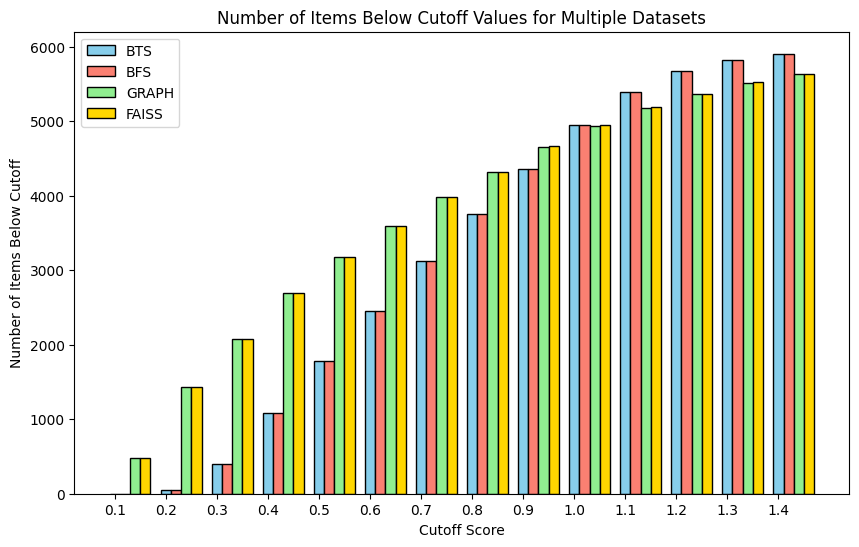

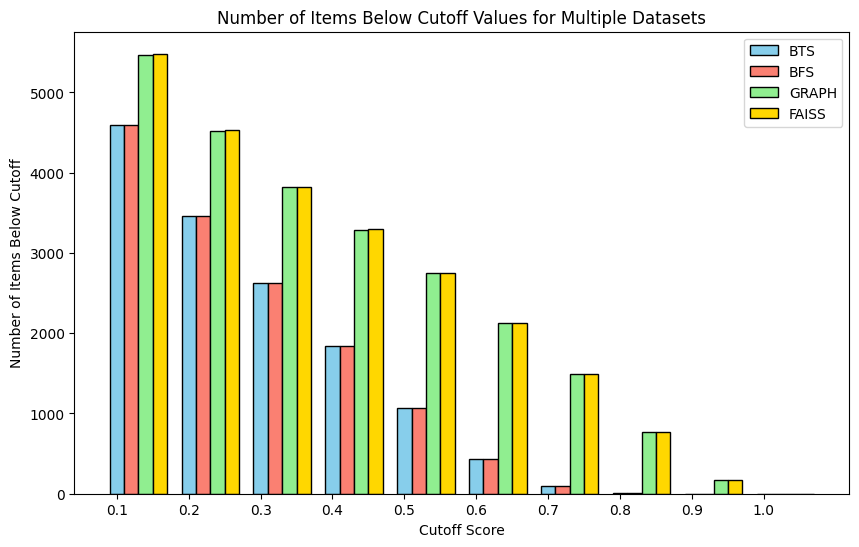

In [6]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def f_ext(file):
    with open(file, 'r') as f:
        obj = json.load(f)
    main_l = []
    for q in obj:
        que = q['Query']['ID'].split(' ')[0][1:]
        t1 = q['Query']['Matches'][0]['ID'].split(' ')[0][1:]
        conf = q['Query']['Confidence']
        score = q['Query']['Matches'][0]['Score']
        main_l.append({'Query' : que, 'T1' : t1, 'Score' : score,'Conf' : conf})
    return pd.DataFrame(main_l)


def plot_multiple_score_distributions(cutoff, conf_flag, *data_lists):
    # Define cutoff values from 0.1 to 1.5 with increments of 0.1
    cutoff_values = np.arange(0.1, cutoff, 0.1)
    labels = ['BTS', 'BFS', 'GRAPH', 'FAISS']
    
    # Colors for each dataset
    colors = ["skyblue", "salmon", "lightgreen", "gold"]
    
    # Plot histogram for each dataset
    plt.figure(figsize=(10, 6))
    for i, data in enumerate(data_lists):
        # Calculate the number of items below each cutoff for the current list
        if conf_flag:
            counts = [np.sum(np.array(data) >= cutoff) for cutoff in cutoff_values]
        else:
            counts = [np.sum(np.array(data) <= cutoff) for cutoff in cutoff_values]
        
        # Plot the histogram for this list
        plt.bar(cutoff_values + i * 0.02, counts, width=0.02, color=colors[i % len(colors)],
                edgecolor="black", align="center", label=labels[i])
        
    # Set plot labels and title
    plt.xlabel("Cutoff Score")
    plt.ylabel("Number of Items Below Cutoff")
    plt.title("Number of Items Below Cutoff Values for Multiple Datasets")
    plt.xticks(cutoff_values)
    plt.legend()
    plt.show()

faiss_json = "/Users/sakshmenon/Desktop/PLM/Data Visualizing/5 Way Venn Plots/faiss_top10.json"
graph_json = "/Users/sakshmenon/Desktop/PLM/Data Visualizing/5 Way Venn Plots/graph_top10.json"
bts_json = "/Users/sakshmenon/Desktop/PLM/Data Visualizing/5 Way Venn Plots/bts_top10.json"
bfs_json = "/Users/sakshmenon/Desktop/PLM/Data Visualizing/5 Way Venn Plots/bfs_top10.json"

faiss_df = f_ext(faiss_json)
graph_df = f_ext(graph_json)
bts_df = f_ext(bts_json)
bfs_df = f_ext(bfs_json)

plot_multiple_score_distributions(1.5, 0,  bts_df['Score'], bfs_df['Score'], graph_df['Score'], faiss_df['Score'])
plot_multiple_score_distributions(1.1, 1, bts_df['Conf'], bfs_df['Conf'], graph_df['Conf'], faiss_df['Conf'])

In [188]:
set_dict = []
for query in set(queries):
    temp = df[df['Query'] == query].sort_values('Score')
    temp = temp.iloc[0][['Query', 'Ref', 'Score']].to_dict()
    set_dict.append(temp)

e_df = pd.DataFrame(set_dict)

0       3.000000e-57
1       3.000000e-48
2       4.600000e-01
3       3.000000e-02
4       1.000000e-51
            ...     
5071    0.000000e+00
5072    4.100000e-02
5073    2.000000e-32
5074    2.500000e-02
5075    2.000000e-94
Name: Score, Length: 5076, dtype: float64